In [2]:

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pandas as pd
import ntpath
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Lambda
from torchvision.transforms.functional import gaussian_blur
import torch.nn.functional as F
from imgaug import augmenters as iaa

# Set device for CUDA acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [3]:

datadir = 'track'
columns = ['center', 'left', 'right',
           'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', None)
data.head()


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [4]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail


data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()


,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


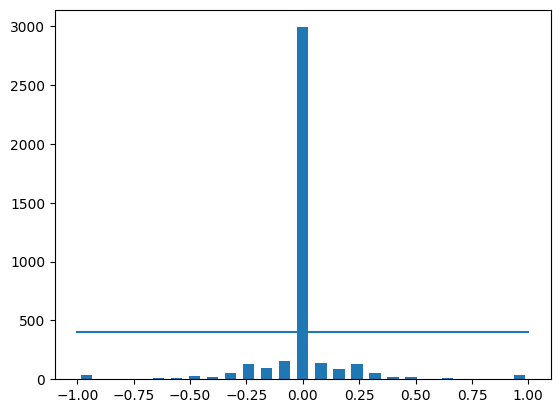

In [5]:

num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(
    data['steering'])), (samples_per_bin, samples_per_bin))


In [6]:

remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if bins[j] <= data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    remove_list.extend(list_[samples_per_bin:])

print('Removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('Remaining:', len(data))


Removed: 2590
Remaining: 1463


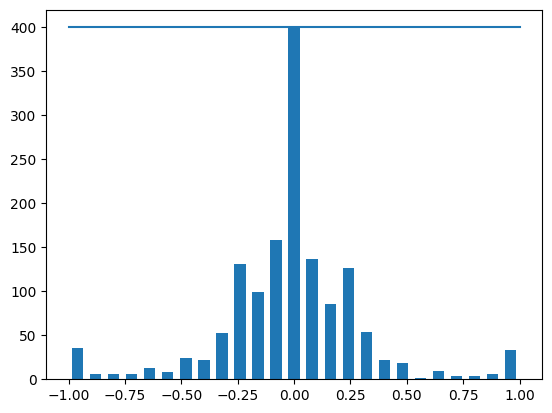

In [7]:

hist, _ = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(
    data['steering'])), (samples_per_bin, samples_per_bin))


In [8]:

def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        # Left image
        image_path.append(os.path.join(datadir, left.strip()))
        steering.append(float(indexed_data[3]) + 0.15)
        # Right image
        image_path.append(os.path.join(datadir, right.strip()))
        steering.append(float(indexed_data[3]) - 0.15)
    return np.array(image_path), np.array(steering)


In [9]:

image_paths, steerings = load_img_steering(os.path.join(datadir, 'IMG'), data)


/tmp/ipykernel_9919/3845878413.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
/tmp/ipykernel_9919/3845878413.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3]))
/tmp/ipykernel_9919/3845878413.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3]) + 0.15)
/tmp/ipykernel_9919/3845878

In [10]:

X_train, X_valid, y_train, y_valid = train_test_split(
    image_paths, steerings, test_size=0.2, random_state=6
)
print(f'Training Samples: {len(X_train)}\nValid Samples: {len(X_valid)}')


Training Samples: 3511
Valid Samples: 878


In [11]:

class DrivingDataset(Dataset):
    def __init__(self, image_paths, steering_angles, is_training=True):
        self.image_paths = image_paths
        self.steering_angles = steering_angles
        self.is_training = is_training

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        steering = self.steering_angles[idx]

        image = mpimg.imread(img_path)

        if self.is_training and random.random() < 0.5:
            image, steering = self.random_augment(image, steering)

        image = self.preprocess(image)
        return image, torch.tensor(steering, dtype=torch.float32)

    def random_augment(self, image, steering):
        if np.random.rand() < 0.5:
            image = iaa.Affine(translate_percent={
                               "x": (-0.1, 0.1), "y": (-0.1, 0.1)}).augment_image(image)
        if np.random.rand() < 0.5:
            image = iaa.Affine(scale=(1, 1.3)).augment_image(image)
        if np.random.rand() < 0.5:
            image = iaa.Multiply((0.2, 1.2)).augment_image(image)
        if np.random.rand() < 0.5:
            image = cv2.flip(image, 1)
            steering = -steering
        return image, steering

    def preprocess(self, image):
        image = image[60:135, :, :]
        image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        image = cv2.GaussianBlur(image, (3, 3), 0)
        image = cv2.resize(image, (200, 66))
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)  # HWC to CHW
        return image



In [12]:

BATCH_SIZE = 100
train_dataset = DrivingDataset(X_train, y_train, is_training=True)
valid_dataset = DrivingDataset(X_valid, y_valid, is_training=False)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


In [13]:

class NVIDIA_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, 3),
            nn.ELU(),
            nn.Conv2d(64, 64, 3),
            nn.ELU(),
            nn.Dropout(0.5)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(1152, 100),
            nn.ELU(),
            nn.Linear(100, 50),
            nn.ELU(),
            nn.Linear(50, 10),
            nn.ELU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


model = NVIDIA_Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [14]:

def train(model, train_loader, valid_loader, epochs):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs.squeeze(),
                                      labels).item() * images.size(0)

        val_loss /= len(valid_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f}')

    return train_losses, val_losses



In [18]:

EPOCHS = 10
train_losses, val_losses = train(model, train_loader, valid_loader, EPOCHS)


Epoch 1/10
Train Loss: 0.1135 | Val Loss: 0.1138
Epoch 2/10
Train Loss: 0.0922 | Val Loss: 0.0868
Epoch 3/10
Train Loss: 0.0835 | Val Loss: 0.0760
Epoch 4/10
Train Loss: 0.0755 | Val Loss: 0.0589
Epoch 5/10
Train Loss: 0.0687 | Val Loss: 0.0572
Epoch 6/10
Train Loss: 0.0650 | Val Loss: 0.0550
Epoch 7/10
Train Loss: 0.0618 | Val Loss: 0.0511
Epoch 8/10
Train Loss: 0.0626 | Val Loss: 0.0531
Epoch 9/10
Train Loss: 0.0602 | Val Loss: 0.0429
Epoch 10/10
Train Loss: 0.0582 | Val Loss: 0.0569


Text(0, 0.5, 'Loss')

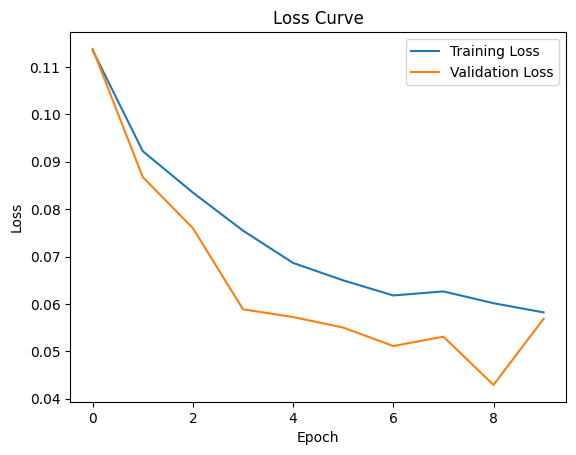

In [19]:

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')


In [17]:

torch.save(model.state_dict(), 'torchmodel/ported-torch-model.pth')